In [67]:
import pandas as pd
import pandas_profiling
import numpy as np

from imblearn.over_sampling import SMOTE

from xgboost.sklearn import XGBClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix
from imblearn.metrics import classification_report_imbalanced


scaler = StandardScaler()

# Loading the data & data exploration

In [178]:
df = pd.read_csv('predict_failure.csv')

In [179]:
# pandas_profiling.ProfileReport(df)

In [141]:
df.describe()

failure    attribute1     attribute2     attribute3  \
count  124494.000000  1.244940e+05  124494.000000  124494.000000   
mean        0.000851  1.223868e+08     159.484762       9.940455   
std         0.029167  7.045960e+07    2179.657730     185.747321   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%         0.000000  6.127675e+07       0.000000       0.000000   
50%         0.000000  1.227957e+08       0.000000       0.000000   
75%         0.000000  1.833084e+08       0.000000       0.000000   
max         1.000000  2.441405e+08   64968.000000   24929.000000   

          attribute4     attribute5     attribute6     attribute7  \
count  124494.000000  124494.000000  124494.000000  124494.000000   
mean        1.741120      14.222693  260172.858025       0.292528   
std        22.908507      15.943021   99151.009852       7.436924   
min         0.000000       1.000000       8.000000       0.000000   
25%         0.000000       8.000000  221452.000000       0.000000   
50%         0.000000      10.000000  249799.500000       0.000000   
75%         0.000000      12.000000  310266.000000       0.000000   
max      1666.000000      98.000000  689161.000000     832.000000   

          attribute8     attribute9  
count  124494.000000  124494.000000  
mean        0.292528      12.451524  
std         7.436924     191.425623  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max       832.000000   18701.000000

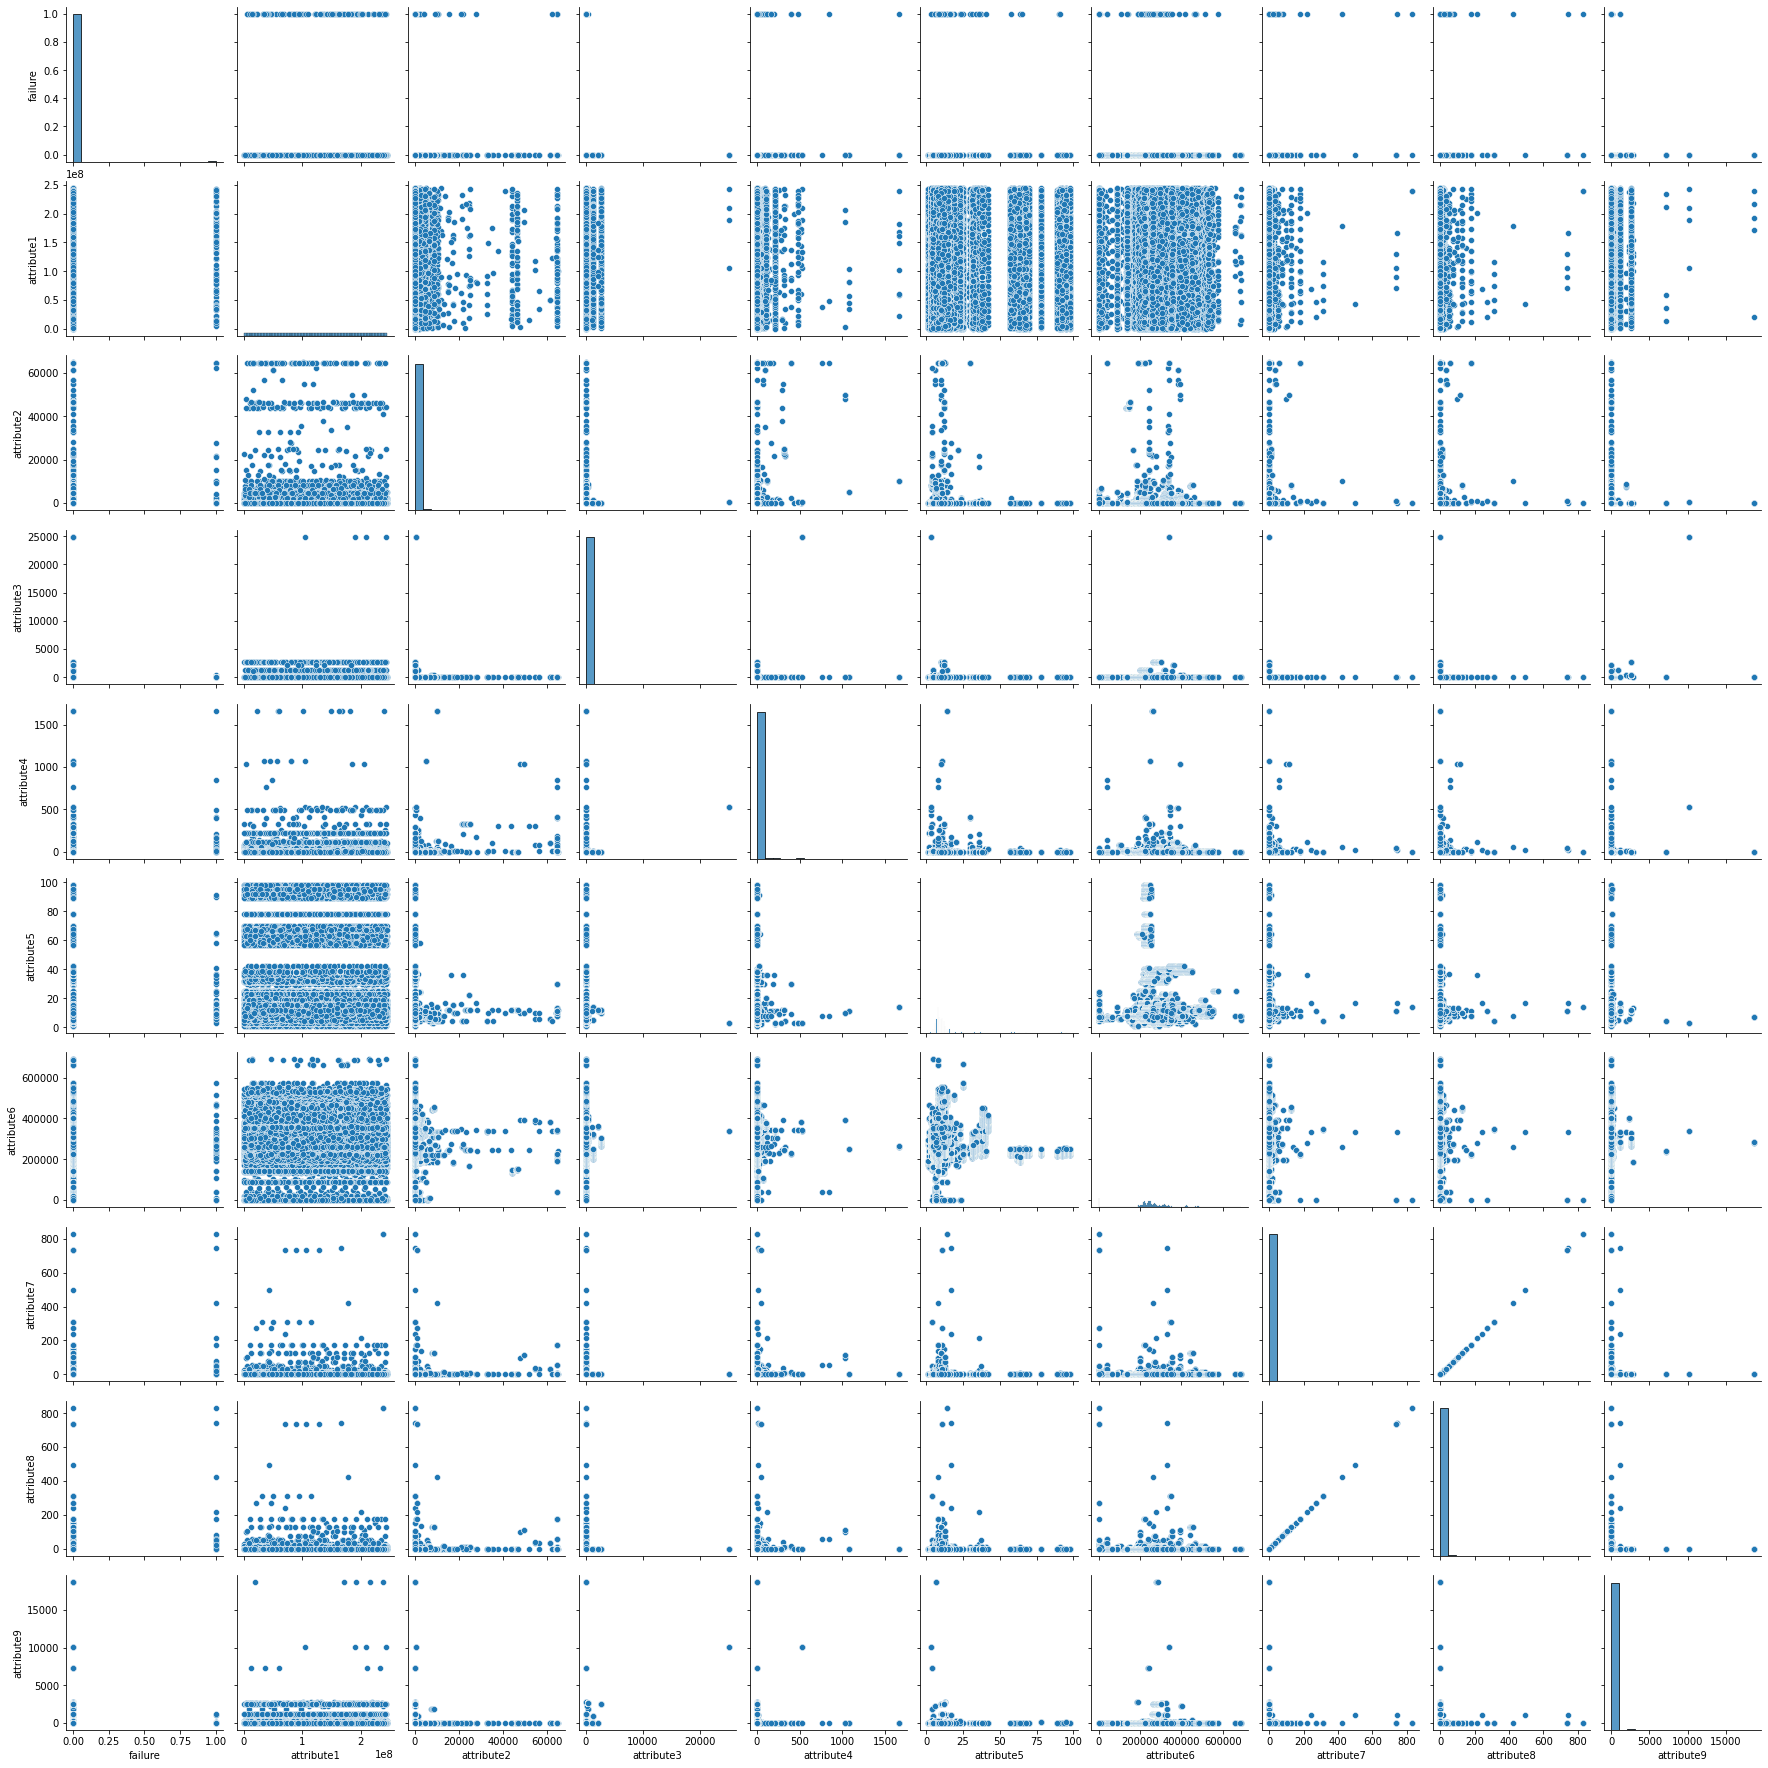

In [82]:
import seaborn as sns
sns.pairplot(df)

In [180]:
(df.attribute8 == df.attribute7).sum() == df.shape[0]

True

### Looks like attribute7 and attribute 8 are exactly the same, so we can drop one of them

In [181]:
pd_data = df.drop('attribute8', axis=1) # drop att 8
pd_data.head()

date    device  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-01  S1F0166B        0    61370680           0           3   
2  2015-01-01  S1F01E6Y        0   173295968           0           0   
3  2015-01-01  S1F01JE0        0    79694024           0           0   
4  2015-01-01  S1F01R2B        0   135970480           0           0   

   attribute4  attribute5  attribute6  attribute7  attribute9  
0          52           6      407438           0           7  
1           0           6      403174           0           0  
2           0          12      237394           0           0  
3           0           6      410186           0           0  
4           0          15      313173           0           3

In [85]:
# number of unique devices
tmp = pd.DataFrame(pd_data.groupby(['device']).agg(['count']))
tmp.shape

(1168, 10)

In [86]:
# number of unique days
tmp = pd.DataFrame(pd_data.groupby(['date']).agg(['count']))
tmp.shape

(304, 10)

In [87]:
# counting devices based on failure or good status
tmp = pd.DataFrame(pd_data.groupby(['failure'])['device'].agg('count'))
tmp

device
failure        
0        124388
1           106

In [88]:
pd_data['failure'].sum()

106

# Lets build a simple model

In [89]:
tmp = pd_data.device.astype('category')
pd_data.device = tmp.cat.codes

In [90]:
pd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  int16 
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute9  124494 non-null  int64 
dtypes: int16(1), int64(9), object(1)
memory usage: 9.7+ MB


In [91]:
import datetime as dt

X=pd_data.drop('failure',axis=1)
y=pd_data['failure']


X['date'] = pd.to_datetime(X['date'])
X['date']=X['date'].map(dt.datetime.toordinal)

X['date'].head()

0    735599
1    735599
2    735599
3    735599
4    735599
Name: date, dtype: int64

In [92]:
X = StandardScaler().fit_transform(X)

In [93]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=60,test_size=0.20) 

### Since data is imbalanced, we have to deal with it; one way is to used a weighted binary cross entropy loss in LR

In [94]:
weights = {0:1.0, 1:(y_train==0).sum()/(y_train==1).sum()}
clf = LogisticRegression(solver='lbfgs', class_weight=weights, random_state=0).fit(X_train, y_train)

In [95]:
y_predict=clf.predict(X_test)

In [96]:
roc_auc = roc_auc_score(y_test, y_predict)
roc_auc

0.7450107886275174

In [97]:
cm = confusion_matrix(y_test, y_predict)
cm

array([[23977,   903],
       [    9,    10]])

In [98]:
f1_score(y_test, y_predict, average='macro')

0.5013979721016869

### f1 score is not good; lets visualize the data to see if it is linearly separable

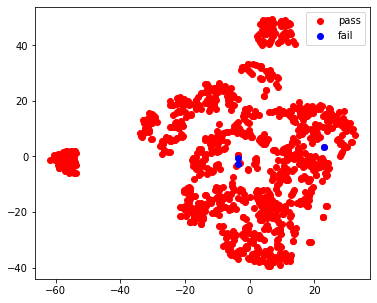

In [99]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X_test[:1000])

target_ids = range(2)
target_names = ['pass', 'fail']

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = 'r', 'b' #, 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(X_2d[y_test[:1000] == i, 0], X_2d[y_test[:1000] == i, 1], c=c, label=label)
plt.legend()
plt.show()

### Initial analysis shows that we need better feature engineering; In the following, we are going to use a aggregate statistics over a window to a failure and use it to train a classifier

## Procedure

In [182]:
pd_data['DATE'] = pd.to_datetime(pd_data['date'])
pd_data = pd_data.rename(columns={"device": "ID"})
pd_data = pd_data.sort_values(by=['ID','DATE'], ascending=[True, True])

# Lets find out when data switches from one device to another 
pd_data['flipper'] = np.where((pd_data.ID != pd_data.ID.shift(1)), 1, 0)
pd_data.head()

date        ID  failure  attribute1  attribute2  attribute3  \
0     2015-01-01  S1F01085        0   215630672          56           0   
1163  2015-01-02  S1F01085        0     1650864          56           0   
2326  2015-01-03  S1F01085        0   124017368          56           0   
3489  2015-01-04  S1F01085        0   128073224          56           0   
4651  2015-01-05  S1F01085        0    97393448          56           0   

      attribute4  attribute5  attribute6  attribute7  attribute9       DATE  \
0             52           6      407438           0           7 2015-01-01   
1163          52           6      407438           0           7 2015-01-02   
2326          52           6      407438           0           7 2015-01-03   
3489          52           6      407439           0           7 2015-01-04   
4651          52           6      408114           0           7 2015-01-05   

      flipper  
0           1  
1163        0  
2326        0  
3489        0  
4651        0

In [183]:
# Select the first record of each machine

dfx = pd_data
starter = dfx[dfx['flipper'] == 1]
starter = starter[['DATE','ID']]

In [184]:
# Rename date to start_date and convert START_DATE to date

starter = starter.rename(index=str, columns={"DATE": "START_DATE"})
starter['START_DATE'] = pd.to_datetime(starter['START_DATE'])

In [185]:
# Merge START_DATE to the original data set

dfx = dfx.sort_values(by=['ID', 'DATE'], ascending=[True, True])
starter = starter.sort_values(by=['ID'], ascending=[True])
dfx = dfx.merge(starter, on=['ID'], how='left')

In [186]:
dfx[:10]

date        ID  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-02  S1F01085        0     1650864          56           0   
2  2015-01-03  S1F01085        0   124017368          56           0   
3  2015-01-04  S1F01085        0   128073224          56           0   
4  2015-01-05  S1F01085        0    97393448          56           0   
5  2015-01-06  S1F01085        0   128832128          56           0   
6  2015-05-06  S1F013BB        0    14533968           0           0   
7  2015-05-07  S1F013BB        0    46202296           0           0   
8  2015-05-08  S1F013BB        0   214383720           0           0   
9  2015-05-09  S1F013BB        0   243346080           0           0   

   attribute4  attribute5  attribute6  attribute7  attribute9       DATE  \
0          52           6      407438           0           7 2015-01-01   
1          52           6      407438           0           7 2015-01-02   
2          52           6      407438           0           7 2015-01-03   
3          52           6      407439           0           7 2015-01-04   
4          52           6      408114           0           7 2015-01-05   
5          52           6      409404           0           7 2015-01-06   
6           0           5      688952           0           0 2015-05-06   
7           0           5      688952           0           0 2015-05-07   
8           0           5      688964           0           0 2015-05-08   
9           0           5      689035           0           0 2015-05-09   

   flipper START_DATE  
0        1 2015-01-01  
1        0 2015-01-01  
2        0 2015-01-01  
3        0 2015-01-01  
4        0 2015-01-01  
5        0 2015-01-01  
6        1 2015-05-06  
7        0 2015-05-06  
8        0 2015-05-06  
9        0 2015-05-06

In [105]:
dfx.columns

Index(['date', 'ID', 'failure', 'attribute1', 'attribute2', 'attribute3',
       'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9',
       'DATE', 'flipper', 'START_DATE'],
      dtype='object')

In [187]:
# Calculate the number of days since the beginning of each device

dfx['tmp'] = dfx['DATE'] - dfx['START_DATE']
dfx['TIME_SINCE_START'] = dfx['tmp'] / np.timedelta64(1, 'D')
dfx = dfx.drop(columns=['tmp'])

In [188]:
# Define a feature window over which aggregate stats are calculated

feature_window = 5
dfx['too_soon'] = np.where((dfx.TIME_SINCE_START < feature_window), 1, 0)

In [189]:
# Calculate the stats
for col in dfx.columns:
    if col.startswith('att'):
        dfx[col+'_mean'] = np.where((dfx.too_soon == 0),(dfx[col].rolling(min_periods=1, window=feature_window).mean()) , dfx[col])
        dfx[col+'_median'] = np.where((dfx.too_soon == 0),(dfx[col].rolling(min_periods=1, window=feature_window).median()) , dfx[col])
        dfx[col+'_max'] = np.where((dfx.too_soon == 0),(dfx[col].rolling(min_periods=1, window=feature_window).max()) , dfx[col])
        dfx[col+'_min'] = np.where((dfx.too_soon == 0),(dfx[col].rolling(min_periods=1, window=feature_window).min()) , dfx[col])
    
dfx.head()

date        ID  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-02  S1F01085        0     1650864          56           0   
2  2015-01-03  S1F01085        0   124017368          56           0   
3  2015-01-04  S1F01085        0   128073224          56           0   
4  2015-01-05  S1F01085        0    97393448          56           0   

   attribute4  attribute5  attribute6  attribute7  ...  attribute6_max  \
0          52           6      407438           0  ...        407438.0   
1          52           6      407438           0  ...        407438.0   
2          52           6      407438           0  ...        407438.0   
3          52           6      407439           0  ...        407439.0   
4          52           6      408114           0  ...        408114.0   

  attribute6_min  attribute7_mean attribute7_median  attribute7_max  \
0       407438.0              0.0               0.0             0.0   
1       407438.0              0.0               0.0             0.0   
2       407438.0              0.0               0.0             0.0   
3       407439.0              0.0               0.0             0.0   
4       408114.0              0.0               0.0             0.0   

   attribute7_min  attribute9_mean  attribute9_median  attribute9_max  \
0             0.0              7.0                7.0             7.0   
1             0.0              7.0                7.0             7.0   
2             0.0              7.0                7.0             7.0   
3             0.0              7.0                7.0             7.0   
4             0.0              7.0                7.0             7.0   

   attribute9_min  
0             7.0  
1             7.0  
2             7.0  
3             7.0  
4             7.0  

[5 rows x 48 columns]

In [190]:
# Copy the data set to the original name

pd_data = dfx

In [191]:
pd_data['failure'].mean()

# highly imbalanced data!

0.000851446656063746

### Lets take a randomly set of devices and place them in either training, testing or validation sets (i.e., no machine can be in two sets at the same time). This allows better generalization (note: it would be worth trying without doing this)

In [192]:
# Find unique devices 

aa = pd_data
pd_id = aa.drop_duplicates(subset='ID')
pd_id = pd_id[['ID']]
pd_id.shape

(1168, 1)

In [193]:
np.random.seed(34)
pd_id['randIdx'] = (np.random.randint(0, 10000, pd_id.shape[0]))/10000
pd_id = pd_id[['ID', 'randIdx']]
pd_id['MODELING_GROUP'] = np.where(((pd_id.randIdx <= 0.35)), 'TRAINING', np.where(((pd_id.randIdx <= 0.65)), 'VALIDATION', 'TESTING'))
tips_summed = pd_id.groupby(['MODELING_GROUP'])['randIdx'].count()
tips_summed

MODELING_GROUP
TESTING       412
TRAINING      410
VALIDATION    346
Name: randIdx, dtype: int64

In [194]:
pd_data = pd_data.sort_values(by=['ID'], ascending=[True])
pd_id = pd_id.sort_values(by=['ID'], ascending=[True])

In [195]:
pd_data =pd_data.merge(pd_id, on=['ID'], how='inner')
pd_data.head()

date        ID  failure  attribute1  attribute2  attribute3  \
0  2015-01-01  S1F01085        0   215630672          56           0   
1  2015-01-02  S1F01085        0     1650864          56           0   
2  2015-01-03  S1F01085        0   124017368          56           0   
3  2015-01-04  S1F01085        0   128073224          56           0   
4  2015-01-05  S1F01085        0    97393448          56           0   

   attribute4  attribute5  attribute6  attribute7  ...  attribute7_mean  \
0          52           6      407438           0  ...              0.0   
1          52           6      407438           0  ...              0.0   
2          52           6      407438           0  ...              0.0   
3          52           6      407439           0  ...              0.0   
4          52           6      408114           0  ...              0.0   

  attribute7_median  attribute7_max attribute7_min  attribute9_mean  \
0               0.0             0.0            0.0              7.0   
1               0.0             0.0            0.0              7.0   
2               0.0             0.0            0.0              7.0   
3               0.0             0.0            0.0              7.0   
4               0.0             0.0            0.0              7.0   

   attribute9_median  attribute9_max  attribute9_min  randIdx  MODELING_GROUP  
0                7.0             7.0             7.0   0.5242      VALIDATION  
1                7.0             7.0             7.0   0.5242      VALIDATION  
2                7.0             7.0             7.0   0.5242      VALIDATION  
3                7.0             7.0             7.0   0.5242      VALIDATION  
4                7.0             7.0             7.0   0.5242      VALIDATION  

[5 rows x 50 columns]

In [196]:
tips_summed = pd_data.groupby(['MODELING_GROUP'])['randIdx'].count()
tips_summed

MODELING_GROUP
TESTING       47653
TRAINING      40618
VALIDATION    36223
Name: randIdx, dtype: int64

In [197]:
tips_summed = pd_data.groupby(['MODELING_GROUP'])['failure'].sum()
tips_summed

# We have about the same number of failures in each set

MODELING_GROUP
TESTING       33
TRAINING      35
VALIDATION    38
Name: failure, dtype: int64

## Lets form the data that will be used later to train the models

In [198]:
len(pd_data)

124494

In [199]:
df_training = pd_data[pd_data['MODELING_GROUP'] == 'TRAINING']
df_training = df_training.drop(columns=['MODELING_GROUP','randIdx','flipper','START_DATE'])
df_training.shape

(40618, 46)

In [200]:
df_train_test = pd_data[pd_data['MODELING_GROUP'] != 'VALIDATION']
df_train_test = df_train_test.drop(columns=['randIdx','flipper','START_DATE'])
df_train_test.shape

(88271, 47)

In [201]:
df_testing=df_train_test[df_train_test['MODELING_GROUP'] == 'TESTING']

In [202]:
df_testing.shape

(47653, 47)

In [203]:
df_total = pd_data.drop(columns=['randIdx','flipper','START_DATE'])
df_total.shape

(124494, 47)

In [204]:
att_list = [att for att in df_training.columns if att.startswith('att') ]
training_features = df_training[att_list]
training_target = df_training[['failure']]

In [205]:
training_features

attribute1  attribute2  attribute3  attribute4  attribute5  \
12         7441792           0           3           0           6   
13       224339296           0           3           0           6   
14        82195688           0           3           0           6   
15       191946112           0           3           0           6   
16        61370680           0           3           0           6   
...            ...         ...         ...         ...         ...   
124406   144206032           0           1           0           1   
124407    58991280           0           1           0           1   
124408   148002792           0           1           0           1   
124409   185118112           0           1           0           1   
124410   150749920           0           1           0           1   

        attribute6  attribute7  attribute9  attribute1_mean  \
12          404786           0           0      116720849.6   
13          403812           0           0      224339296.0   
14          403175           0           0       82195688.0   
15          403174           0           0      191946112.0   
16          403174           0           0       61370680.0   
...            ...         ...         ...              ...   
124406      190173           0           0       95878804.8   
124407      190173           0           0       85110716.8   
124408      190173           0           0      128656284.8   
124409      190173           0           0      146419484.8   
124410      190173           0           0      110853982.4   

        attribute1_median  ...  attribute6_max  attribute6_min  \
12             82195688.0  ...        404786.0        403174.0   
13            224339296.0  ...        403812.0        403812.0   
14             82195688.0  ...        403175.0        403175.0   
15            191946112.0  ...        403174.0        403174.0   
16             61370680.0  ...        403174.0        403174.0   
...                   ...  ...             ...             ...   
124406         96302112.0  ...        190173.0        190152.0   
124407         58991280.0  ...        190173.0        189354.0   
124408        144206032.0  ...        190173.0        190173.0   
124409        148002792.0  ...        190173.0        190173.0   
124410        104020568.0  ...        190173.0        190173.0   

        attribute7_mean  attribute7_median  attribute7_max  attribute7_min  \
12                  0.0                0.0             0.0             0.0   
13                  0.0                0.0             0.0             0.0   
14                  0.0                0.0             0.0             0.0   
15                  0.0                0.0             0.0             0.0   
16                  0.0                0.0             0.0             0.0   
...                 ...                ...             ...             ...   
124406              0.0                0.0             0.0             0.0   
124407              0.0                0.0             0.0             0.0   
124408              0.0                0.0             0.0             0.0   
124409              0.0                0.0             0.0             0.0   
124410              0.0                0.0             0.0             0.0   

        attribute9_mean  attribute9_median  attribute9_max  attribute9_min  
12                  0.0                0.0             0.0             0.0  
13                  0.0                0.0             0.0             0.0  
14                  0.0                0.0             0.0             0.0  
15                  0.0                0.0             0.0             0.0  
16                  0.0                0.0             0.0             0.0  
...                 ...                ...             ...             ...  
124406              0.0                0.0             0.0             0.0  
124407              0.0                0.0             0.0      

### Now is time to balance the dataset

In [206]:
from imblearn.over_sampling import SMOTE
smx = SMOTE(random_state=10) 

In [207]:
x_res, y_res = smx.fit_sample(training_features, training_target.values.ravel())

In [208]:
df_x = pd.DataFrame(x_res)
df_x.columns = att_list
df_x.head()

attribute1  attribute2  attribute3  attribute4  attribute5  attribute6  \
0     7441792           0           3           0           6      404786   
1   224339296           0           3           0           6      403812   
2    82195688           0           3           0           6      403175   
3   191946112           0           3           0           6      403174   
4    61370680           0           3           0           6      403174   

   attribute7  attribute9  attribute1_mean  attribute1_median  ...  \
0           0           0      116720849.6         82195688.0  ...   
1           0           0      224339296.0        224339296.0  ...   
2           0           0       82195688.0         82195688.0  ...   
3           0           0      191946112.0        191946112.0  ...   
4           0           0       61370680.0         61370680.0  ...   

   attribute6_max  attribute6_min  attribute7_mean  attribute7_median  \
0        404786.0        403174.0              0.0                0.0   
1        403812.0        403812.0              0.0                0.0   
2        403175.0        403175.0              0.0                0.0   
3        403174.0        403174.0              0.0                0.0   
4        403174.0        403174.0              0.0                0.0   

   attribute7_max  attribute7_min  attribute9_mean  attribute9_median  \
0             0.0             0.0              0.0                0.0   
1             0.0             0.0              0.0                0.0   
2             0.0             0.0              0.0                0.0   
3             0.0             0.0              0.0                0.0   
4             0.0             0.0              0.0                0.0   

   attribute9_max  attribute9_min  
0             0.0             0.0  
1             0.0             0.0  
2             0.0             0.0  
3             0.0             0.0  
4             0.0             0.0  

[5 rows x 40 columns]

In [209]:
df_y = pd.DataFrame(y_res)
df_y.columns = ['failure']

In [210]:
df_y.mean(axis = 0)

# So, as you can see data is balanced now!

failure    0.5
dtype: float64

In [211]:
df_balanced = pd.concat([df_y, df_x], axis=1)
df_balanced.head()

failure  attribute1  attribute2  attribute3  attribute4  attribute5  \
0        0     7441792           0           3           0           6   
1        0   224339296           0           3           0           6   
2        0    82195688           0           3           0           6   
3        0   191946112           0           3           0           6   
4        0    61370680           0           3           0           6   

   attribute6  attribute7  attribute9  attribute1_mean  ...  attribute6_max  \
0      404786           0           0      116720849.6  ...        404786.0   
1      403812           0           0      224339296.0  ...        403812.0   
2      403175           0           0       82195688.0  ...        403175.0   
3      403174           0           0      191946112.0  ...        403174.0   
4      403174           0           0       61370680.0  ...        403174.0   

   attribute6_min  attribute7_mean  attribute7_median  attribute7_max  \
0        403174.0              0.0                0.0             0.0   
1        403812.0              0.0                0.0             0.0   
2        403175.0              0.0                0.0             0.0   
3        403174.0              0.0                0.0             0.0   
4        403174.0              0.0                0.0             0.0   

   attribute7_min  attribute9_mean  attribute9_median  attribute9_max  \
0             0.0              0.0                0.0             0.0   
1             0.0              0.0                0.0             0.0   
2             0.0              0.0                0.0             0.0   
3             0.0              0.0                0.0             0.0   
4             0.0              0.0                0.0             0.0   

   attribute9_min  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  

[5 rows x 41 columns]

In [212]:
len(df_balanced)

81166

# Build the model on the balanced training data set and evaluate it on the unbalanced training and testing data set.


In [213]:
features = [x for x in df_balanced.columns if x not in ['failure']]  
dependent = pd.DataFrame(df_balanced['failure'])
independent = df_balanced.drop(columns=['failure'])

In [214]:
# Make sure everything is numeric for simplicity
independent = independent.apply(pd.to_numeric) 
df_balanced = df_balanced.apply(pd.to_numeric)

In [215]:
log = LogisticRegression()
xgb0 = XGBClassifier(objective= 'binary:logistic')
gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier(n_estimators=10)

algorithms=[log, xgb0, gbc, rfc]
names = ['Logistic', 'xgboost', 'GradientBoost', 'RandomForest']


 Logistic -----------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.81      0.36      0.89      0.54      0.31     47620
          1       0.00      0.36      0.81      0.00      0.54      0.28        33

avg / total       1.00      0.81      0.36      0.89      0.54      0.31     47653

test accuracy: 0.8069586384907561

 col_0        0     1
failure             
0        38442  9178
1           21    12

 xgboost -----------------------------------------------
[12:06:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.15      1.00      0.39

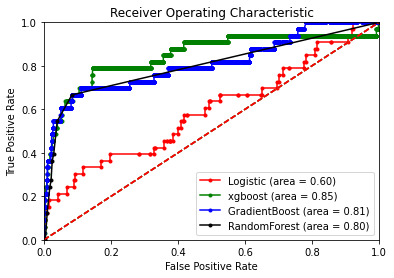

In [216]:
import warnings
warnings.filterwarnings("ignore")

X_test = df_testing[features]
y_test = df_testing['failure']

markerfacecolors = ['red', 'green', 'blue', 'black']
 
for idx, (alg, name) in enumerate(zip(algorithms, names)):
    print('\n', name, '-----------------------------------------------')
    alg.fit(independent[features], dependent['failure']) #, eval_metric='auc')
    
    probs = alg.predict_proba(X_test)[:,1]
    
    preds = alg.predict(X_test).round()
    print(classification_report_imbalanced(y_test,preds))
    
    print(f'test accuracy: {(y_test==preds).sum() / len(y_test)}')
    
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    
    print('\n', pd.crosstab(y_test, preds, dropna=False))
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.', color=markerfacecolors[idx],label= f'{name} (area = {roc_auc:.2f})')
    

    
plt.title('Receiver Operating Characteristic')    
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusion: 
### The gradientboost model seems to perform better than other models in general. It has better recall over the failure class leading to high F1. A grid serach over the feature window will likely improve the results.

# Deployment

### We will create a class here that can be used to train and test the model. It takes the input csv file and feature window as paramters.

In [218]:
from model import *

In [219]:
pm_model = predictiveMaintenance('predict_failure.csv')

In [220]:
pm_model.train()

[12:11:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [221]:
output  = pm_model.test('predict_failure.csv')

In [222]:
output

date    device  failure  attribute1  attribute2  attribute3  \
0       2015-01-01  S1F01085        0   215630672          56           0   
1       2015-01-01  S1F0166B        0    61370680           0           3   
2       2015-01-01  S1F01E6Y        0   173295968           0           0   
3       2015-01-01  S1F01JE0        0    79694024           0           0   
4       2015-01-01  S1F01R2B        0   135970480           0           0   
...            ...       ...      ...         ...         ...         ...   
124489  2015-11-02  Z1F0MA1S        0    18310224           0           0   
124490  2015-11-02  Z1F0Q8RT        0   172556680          96         107   
124491  2015-11-02  Z1F0QK05        0    19029120        4832           0   
124492  2015-11-02  Z1F0QL3N        0   226953408           0           0   
124493  2015-11-02  Z1F0QLC1        0    17572840           0           0   

        attribute4  attribute5  attribute6  attribute7  attribute8  \
0               52           6      407438           0           0   
1                0           6      403174           0           0   
2                0          12      237394           0           0   
3                0           6      410186           0           0   
4                0          15      313173           0           0   
...            ...         ...         ...         ...         ...   
124489           0          10      353705           8           8   
124490           4          11      332792           0           0   
124491           0          11      350410           0           0   
124492           0          12      358980           0           0   
124493           0          10      351431           0           0   

        attribute9  prob_failure  
0                7      0.000301  
1                0      0.003840  
2                0      0.000709  
3                0      0.001065  
4                3      0.004449  
...            ...           ...  
124489           0      0.000001  
124490          13      0.000009  
124491           0      0.000003  
124492           0      0.000001  
124493           0      0.000001  

[124494 rows x 13 columns]

In [223]:
output.to_csv (r'processed_file.csv', index = False, header=True)

### The last column in the above csv file is the probability of failure.

## dependencies

In [3]:
conda env list

# conda environments:
#
base                     /Users/ali/anaconda3
ali                   *  /Users/ali/anaconda3/envs/ali
tf                       /Users/ali/anaconda3/envs/tf
tf-onnx                  /Users/ali/anaconda3/envs/tf-onnx
yolov3-cpu               /Users/ali/anaconda3/envs/yolov3-cpu


Note: you may need to restart the kernel to use updated packages.


In [21]:
!pip freeze >> requirements.txt 

In [22]:
conda env export > ali.yml


Note: you may need to restart the kernel to use updated packages.
